In [2]:
import numpy as np    # 数学运算库
import pandas as pd    # 数据分析库

# 读取数据
handleddata = pd.read_csv('HandledData.csv')
print(handleddata.head(8))    # 显示数据前8行

   股票编号    年份（年末）        股价  每股收益(期末摊薄，元/股)  每股净资产(元/股)  每股资本公积(元/股)  \
0     1  0.000000  0.017112        0.234841    0.059202     0.019979   
1     1  0.149633  0.012762        0.237062    0.060480     0.020115   
2     1  0.289510  0.014238        0.225513    0.060306     0.019459   
3     1  0.412408  0.013235        0.219839    0.058819     0.018479   
4     1  0.517458  0.021047        0.194939    0.055489     0.017389   
5     1  0.598626  0.022193        0.188808    0.052896     0.016094   
6     1  0.667950  0.025604        0.186129    0.051544     0.014956   
7     2  0.000000  0.000000        0.422483    0.125114     0.060585   

   每股盈余公积(元/股)  每股公积金(元/股)  每股未分配利润(元/股)  每股留存收益(元/股)  每股现金流量净额(元/股)  \
0     0.006897    0.014430      0.188296     0.174671       0.400316   
1     0.009915    0.014933      0.190665     0.177422       0.397472   
2     0.011331    0.014624      0.189629     0.176744       0.383200   
3     0.012096    0.014024      0.184503     0.172176       0.3

In [3]:
# 统计是否高送转有多少个0和1 高转送：high delivery：hd
count_hds = pd.value_counts(handleddata['是否高转送'])
# print(count_hds)
# 0    21101
# 1     3161
# Name: 是否高转送, dtype: int64

In [4]:
# 欠采样处理 UnderSampled 得到欠采样后数据

# 从原始数据中得到X和y
X = handleddata.loc[:, handleddata.columns != '是否高转送']    # 拿非‘是否高转送‘特征 取行
y = handleddata.loc[:, handleddata.columns == '是否高转送']    # 拿‘是否高转送‘特征 取行

number_records_fraud = len(handleddata[handleddata.是否高转送 == 1])    # 计算少数类别 1 的样本个数
number_records_normal = len(handleddata[handleddata.是否高转送 == 0])    # 计算多数类别 0 的样本个数
# print(number_records_fraud)
# print(number_records_normal)
# 3161
# 21101

fraud_indices = np.array(handleddata[handleddata.是否高转送 == 1].index)    # 求出少数类别 1 的样本对应的索引值
normal_indices = np.array(handleddata[handleddata.是否高转送 == 0].index)    # 求出多数类别 0 的样本对应的索引值

# 从多数类别 0 样本中随机筛选出 number_records_fraud个样本
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)    # 参数1: 样本集 参数2：抽取个数 参数3: 是否取代原来的数据，如果False则通过返回值返回
# print(len(random_normal_indices))    # 3161
# print(random_normal_indices)

# 混合random_normal_indices和fraud_indices作为欠采样UnderSampled的学习样本 此时仍是样本对应索引值
under_sampled_indices = np.concatenate((random_normal_indices, fraud_indices), axis = 0)    # 参数1：元组，要整合的所有数据 参数2：axis，整合的方向，0代表行（样本），1代表列（特征）
# print(len(under_sampled_indices))    # 6322

# 从原始数据中根据对应索引值获取UnderSampled数据
under_sampled_data = handleddata.iloc[under_sampled_indices, :]    # iloc取行
# 得到X_undersampled和y_undersampled
X_undersampled = under_sampled_data.iloc[:, handleddata.columns != '是否高转送']
y_undersampled = under_sampled_data.iloc[:, handleddata.columns == '是否高转送']
# print(y_undersampled)

In [5]:
# 给UnderSampled数据划分训练集，验证集，测试集 占比（7）：3
from sklearn.model_selection import train_test_split

X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled, y_undersampled, test_size = 0.3, random_state = 0)
print('对Undersampled数据进行划分，训练集+验证集数据的长度是：', len(y_train_undersampled))    # 4425
print('对Undersampled数据进行划分，测试集数据的长度是：', len(y_test_undersampled))    # 1897
print('总共的数据量是：', len(y_train_undersampled) + len(y_test_undersampled))    # 6322

# 给原始数据划分训练集，验证集，测试集 占比（7）：3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print('对Undersampled数据进行划分，训练集+验证集数据的长度是：', len(y_train))    # 16983
print('对Undersampled数据进行划分，测试集数据的长度是：', len(y_test))    # 7279
print('总共的数据量是：', len(y_train) + len(y_test))    # 24262

对Undersampled数据进行划分，训练集+验证集数据的长度是： 4425
对Undersampled数据进行划分，测试集数据的长度是： 1897
总共的数据量是： 6322
对Undersampled数据进行划分，训练集+验证集数据的长度是： 16983
对Undersampled数据进行划分，测试集数据的长度是： 7279
总共的数据量是： 24262


In [6]:
# 开始机器学习
# 导入机器学习的库
from sklearn.linear_model import LogisticRegression    # 逻辑回归
from sklearn.model_selection import KFold, cross_val_score    # K折交叉验证
from sklearn.metrics import confusion_matrix, recall_score, classification_report    # 混淆矩阵，召回率计算，显示分类指标

In [7]:
# K折的函数
def KFold_score(X_train_data, y_train_data):
    fold = KFold(n_splits = 5, shuffle = False, random_state = 0)
    c_param_range = [0.01, 0.1, 1, 10, 100]
    result_table = pd.DataFrame(index = range(len(c_param_range)), columns = ['C参数', 'recall值'])
    j = 0
    for c_param in c_param_range:
        result_table.loc[j, 'C参数'] = c_param
        recall_accs = []
        iteration = 0
        for train_index, valid_index in fold.split(X_train_data):
            # print('训练集：', len(train_index), '，验证集：', len(valid_index))
            lr = LogisticRegression(penalty = 'l1', C = c_param, solver = 'liblinear')
            lr.fit(X_train_data.iloc[train_index, :], y_train_data.iloc[train_index, :].values.ravel())
            y_pred = lr.predict(X_train_data.iloc[valid_index, :].values)
            recall_acc = recall_score(y_train_data.iloc[valid_index, :], y_pred)
            iteration += 1
            print('id：', iteration, '，recall的值为：', recall_acc)
            recall_accs.append(recall_acc)
        result_table.loc[j, 'recall值'] = np.mean(recall_accs)
        print('平均的recall值为：', np.mean(recall_accs))
        j += 1
    print(result_table)
    maxval = 0
    maxid = -1
    for id, val in enumerate(result_table['recall值']):
        print('id：', id, '，val：', val)
        if val > maxval:
            maxval = val
            maxid = id
    best_c = result_table.loc[maxid]['C参数']
    print('最优的C值是：', best_c)
    return best_c

best_c = KFold_score(X_train_undersampled, y_train_undersampled)
print('最优的C值是：', best_c)

/Users/huanghuimin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


id： 1 ，recall的值为： 1.0
id： 2 ，recall的值为： 1.0
id： 3 ，recall的值为： 1.0
id： 4 ，recall的值为： 1.0
id： 5 ，recall的值为： 1.0
平均的recall值为： 1.0
id： 1 ，recall的值为： 0.6735159817351598
id： 2 ，recall的值为： 0.663594470046083
id： 3 ，recall的值为： 0.691415313225058
id： 4 ，recall的值为： 0.6608695652173913
id： 5 ，recall的值为： 0.6383928571428571
平均的recall值为： 0.6655576374733099
id： 1 ，recall的值为： 0.7054794520547946
id： 2 ，recall的值为： 0.7004608294930875
id： 3 ，recall的值为： 0.7378190255220418
id： 4 ，recall的值为： 0.7086956521739131
id： 5 ，recall的值为： 0.6852678571428571
平均的recall值为： 0.7075445632773388
id： 1 ，recall的值为： 0.7214611872146118
id： 2 ，recall的值为： 0.7235023041474654
id： 3 ，recall的值为： 0.7517401392111369


/Users/huanghuimin/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


id： 4 ，recall的值为： 0.7326086956521739
id： 5 ，recall的值为： 0.6785714285714286
平均的recall值为： 0.7215767509593635
id： 1 ，recall的值为： 0.7214611872146118
id： 2 ，recall的值为： 0.7211981566820277
id： 3 ，recall的值为： 0.7517401392111369


/Users/huanghuimin/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


id： 4 ，recall的值为： 0.7304347826086957
id： 5 ，recall的值为： 0.6808035714285714
平均的recall值为： 0.7211275674290087
    C参数   recall值
0  0.01         1
1   0.1  0.665558
2     1  0.707545
3    10  0.721577
4   100  0.721128
id： 0 ，val： 1.0
id： 1 ，val： 0.6655576374733099
id： 2 ，val： 0.7075445632773388
id： 3 ，val： 0.7215767509593635
id： 4 ，val： 0.7211275674290087
最优的C值是： 0.01
最优的C值是： 0.01


In [32]:
# import matplotlib
# font_list=sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
# for i in font_list:
#     print (i)

.Aqua Kana
.Arabic UI Display
.Arabic UI Text
.Helvetica Neue DeskInterface
.Keyboard
.LastResort
.New York
.New York
.SF Compact Display
.SF Compact Rounded
.SF Compact Text
.SF Compact Text
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Mono
.SF NS Mono
.SF NS Rounded
.SF NS Text Condensed
.SF NS Text Condensed
.SF NS Text Condensed
.SF NS Text Condensed
.SF NS Text Condensed
.SF NS Text Condensed
Al Bayan
Al Nile
Al Tarikh
American Typewriter
Andale Mono
Apple Braille
Apple Braille
Apple Braille
Apple Braille
Apple Braille
Apple Chancery
Apple SD Gothic Neo
Apple Symbols
AppleGothic
AppleMyungjo
Arial
Arial
Arial
Arial
Arial Black
Arial Hebrew
Arial Narrow
Arial Narrow
Arial Narrow
Arial Narrow
Arial Rounded MT Bold
Arial Unicode MS
Athelas
Avenir
Avenir Next
Avenir Next Condensed
Ayuthaya
Baghdad
Ban

In [8]:
# 绘图库
import matplotlib.pyplot as plt

count_classes = pd.value_counts(handleddata['是否高转送'])
plt.rcParams['font.family'] = ['Arial Unicode MS'] #正常显示中文 
plt.rcParams['font.sans-serif'] = ['KaiTi']#作图的中文
plt.rcParams['font.serif'] = ['KaiTi']#作图的中文
plt.rcParams['axes.unicode_minus'] = False
# count_classes.plot(kind = 'bar')
# plt.title('是否高转送统计')
# plt.xlabel('分类')
# plt.ylabel('数量')
# plt.show()

In [9]:
# 绘制混淆矩阵的函数
def plot_confusion_matrix(cm, cmap = plt.cm.Blues, title = '混淆矩阵'):
    plt.imshow(cm, cmap = cmap)
    plt.title(title)
    plt.xlabel('预测值')
    plt.ylabel('真实值')
    plt.xticks(range(2))
    plt.yticks(range(2))
    plt.colorbar()
    max = 0
    for i in range(2):
        for j in range(2):
            if cm[i][j] > max:
                max = cm[i][j]
    for i in range(2):
        for j in range(2):
            if cm[i][j] > max / 2:
                color = 'white'
            else:
                color = 'black'
            plt.text(j, i, cm[i][j], color = color)


recall值为： 0.7147368421052631
precision值为： 0.7913752913752914


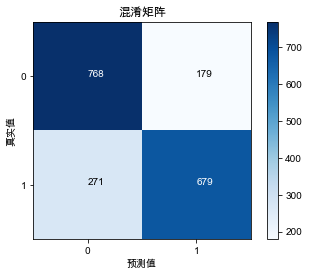

In [15]:
# 使用真实欠采样数据绘制混淆矩阵
lr = LogisticRegression(penalty = 'l1', C = best_c, solver = 'liblinear')
lr.fit(X_train_undersampled, y_train_undersampled.values.ravel())
y_pred_undersampled = lr.predict(X_test_undersampled.values)
cnf_matrix = confusion_matrix(y_test_undersampled, y_pred_undersampled)
recall = cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[1][0])
print('recall值为：', recall)
precision = cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[0][1])
print('precision值为：', precision)
plt.clf()
plot_confusion_matrix(cnf_matrix)
plt.show()

/Users/huanghuimin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


id： 1 ，recall的值为： 0.0
id： 2 ，recall的值为： 0.0
id： 3 ，recall的值为： 0.0
id： 4 ，recall的值为： 0.0
id： 5 ，recall的值为： 0.0
平均的recall值为： 0.0
id： 1 ，recall的值为： 0.10714285714285714
id： 2 ，recall的值为： 0.10151187904967603
id： 3 ，recall的值为： 0.09684684684684684
id： 4 ，recall的值为： 0.12472160356347439
id： 5 ，recall的值为： 0.09953703703703703
平均的recall值为： 0.1059520447279783
id： 1 ，recall的值为： 0.18080357142857142
id： 2 ，recall的值为： 0.19870410367170627
id： 3 ，recall的值为： 0.18018018018018017
id： 4 ，recall的值为： 0.21158129175946547
id： 5 ，recall的值为： 0.17592592592592593
平均的recall值为： 0.18943901459316986
id： 1 ，recall的值为： 0.21205357142857142
id： 2 ，recall的值为： 0.20302375809935205
id： 3 ，recall的值为： 0.19594594594594594
id： 4 ，recall的值为： 0.22271714922049
id： 5 ，recall的值为： 0.19444444444444445
平均的recall值为： 0.20563697382776075
id： 1 ，recall的值为： 0.18303571428571427
id： 2 ，recall的值为： 0.19222462203023757
id： 3 ，recall的值为： 0.1891891891891892
id： 4 ，recall的值为： 0.24053452115812918
id： 5 ，recall的值为： 0.19675925925925927
平均的recall值为： 0.2003

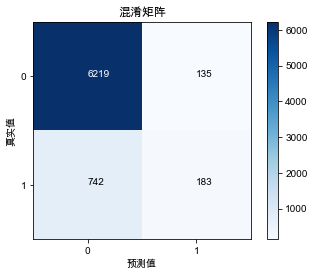

In [11]:
# 拿原始数据进行K折交叉验证
best_c = KFold_score(X_train, y_train)
# 在原始数据测试集上进行测试
lr = LogisticRegression(penalty = 'l1', C = best_c, solver = 'liblinear')
lr.fit(X_train, y_train.values.ravel())
y_pred = lr.predict(X_test.values)
cnf_matrix = confusion_matrix(y_test, y_pred)
recall = cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[1][0])
print('recall值为：', recall)
precision = cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[0][1])
print('precision值为：', precision)
plt.clf()
plot_confusion_matrix(cnf_matrix)
plt.show()

In [13]:
# 进行过采样数据处理
# 导入OverSampled对应的开发包
from imblearn.over_sampling import SMOTE

oversampled = SMOTE()
X_train_oversampled, y_train_oversampled = oversampled.fit_sample(X_train, y_train)
# print(np.sum(y_train_oversampled == 1))
# print(np.sum(y_train_oversampled == 0))
# print(y_train_oversampled.size)
# 是否高转送    14747
# dtype: int64
# 是否高转送    14747
# dtype: int64
# 29494
# 重新计算C参数
X_train_oversampled = pd.DataFrame(X_train_oversampled)
y_train_oversampled = pd.DataFrame(y_train_oversampled)
best_c = KFold_score(X_train_oversampled, y_train_oversampled)
print('最优的C参数值是：', best_c)    # 10

/Users/huanghuimin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


id： 1 ，recall的值为： 0.8656330749354005
id： 2 ，recall的值为： 0.8807453416149068
id： 3 ，recall的值为： 0.8643326039387309
id： 4 ，recall的值为： 0.33056450245804375
id： 5 ，recall的值为： 0.3375720583248559
平均的recall值为： 0.6557695162543876
id： 1 ，recall的值为： 0.7739018087855297
id： 2 ，recall的值为： 0.7801242236024845
id： 3 ，recall的值为： 0.812545587162655
id： 4 ，recall的值为： 0.592303780301746
id： 5 ，recall的值为： 0.6120718887758563
平均的recall值为： 0.7141894577256542
id： 1 ，recall的值为： 0.7648578811369509
id： 2 ，recall的值为： 0.7788819875776397
id： 3 ，recall的值为： 0.8132749817651349
id： 4 ，recall的值为： 0.6240040684861841
id： 5 ，recall的值为： 0.6492031197015937
平均的recall值为： 0.7260444077335005
id： 1 ，recall的值为： 0.7609819121447028
id： 2 ，recall的值为： 0.7763975155279503
id： 3 ，recall的值为： 0.8132749817651349
id： 4 ，recall的值为： 0.625699271062892
id： 5 ，recall的值为： 0.6539504916920991
平均的recall值为： 0.7260608344385558
id： 1 ，recall的值为： 0.7700258397932817
id： 2 ，recall的值为： 0.7751552795031056
id： 3 ，recall的值为： 0.8154631655725748
id： 4 ，recall的值为： 0.610

recall值为： 0.7091891891891892
precision值为： 0.34949387320191794


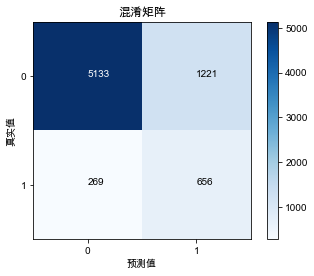

In [16]:
# 在oversampled数据测试集上进行测试
lr = LogisticRegression(penalty = 'l1', C = best_c, solver = 'liblinear')
lr.fit(X_train_oversampled, y_train_oversampled.values.ravel())
y_pred = lr.predict(X_test.values)
cnf_matrix = confusion_matrix(y_test, y_pred)
recall = cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[1][0])
print('recall值为：', recall)
precision = cnf_matrix[1][1] / (cnf_matrix[1][1] + cnf_matrix[0][1])
print('precision值为：', precision)
plt.clf()
plot_confusion_matrix(cnf_matrix)
plt.show()